# Converting RGB images into positive pixel masks

After we've extracted the data from the WSI's, it's time to convert these RGB images in binary image masks. These masks contain pixel classification decisions made by SANA based on the parameters we set.

## Part 0: Prepare the input data

This cell uses code from Parts 2 and 3 from example0_prepare_images to load ROIs into memory

2025-04-29 13:21:58,074 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Loading Frame from .svs slide file...
2025-04-29 13:21:58,141 :: DEBUG :: logging.py :: <func> debug :: Line: 72 :: Done I/O (0.07 sec)


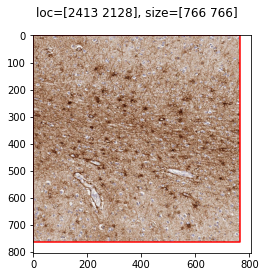

In [3]:
interactive_plots = False
if interactive_plots:
    %matplotlib qt
else:
    %matplotlib inline

import os
import geojson
import numpy as np
import sana.logging
import sana.process
import sana.slide
import sana.filter

# parses geojson files
def load_annotations(f, class_name, roi_name=None):
    out = []
    annotations = geojson.load(open(f, 'r'))["features"]
    for annotation in annotations:
        if annotation["properties"]["classification"]["name"] == class_name and (roi_name is None or annotation["properties"]["name"] == roi_name):
            if annotation["geometry"]["type"] == "Polygon":
                x, y = np.array(annotation["geometry"]["coordinates"][0]).T
                out.append(sana.geo.Polygon(x, y, is_micron=False, level=0))
            elif annotation["geometry"]["type"] == "LineString":
                x, y = np.array(annotation["geometry"]["coordinates"]).T
                out.append(sana.geo.Curve(x, y, is_micron=False, level=0))

    return out

SANAPATH = os.path.expanduser('~/sana_builds/main')


# load the ROI frame
f = f'{SANAPATH}/docs/source/resources/example.geojson'
main_roi = load_annotations(f, "ROI")[0]
sub_rois = [load_annotations(f, "SUB_A")[0], load_annotations(f, "SUB_B")[0]]
exclusion_rois = load_annotations(f, "EXCLUDE")
logger = sana.logging.Logger(debug_level='full', fpath=f'{SANAPATH}/docs/source/resources/example.pkl')
loader = sana.slide.Loader(logger, f'{SANAPATH}/docs/source/resources/example.tif', mpp=0.25225)
frame = loader.load_frame_with_roi(main_roi, level=0)

# transform the annotations into the frame's coordinate space
main_roi = sana.geo.transform_array_with_logger(main_roi, logger)
sub_rois = [sana.geo.transform_array_with_logger(x, logger) for x in sub_rois]
exclusion_rois = [sana.geo.transform_array_with_logger(exclusion_roi, logger) for exclusion_roi in exclusion_rois]


## Part 1: Extract the DAB

The Processor object converts the input RGB frame to positive pixel masks using an adaptive thresholding algorithm. Before accomplishing this, we must perform a few preprocessing steps.

We apply a color deconvolution which separates the individual stains in this RGB image. This slide was stained with Hematoxylin and DAB. 

Additionally, SANA optionally applies a smoothing operation and a background normalization operation. Please familiarize yourself with the parameters at this step by trying different combinations to see the effects

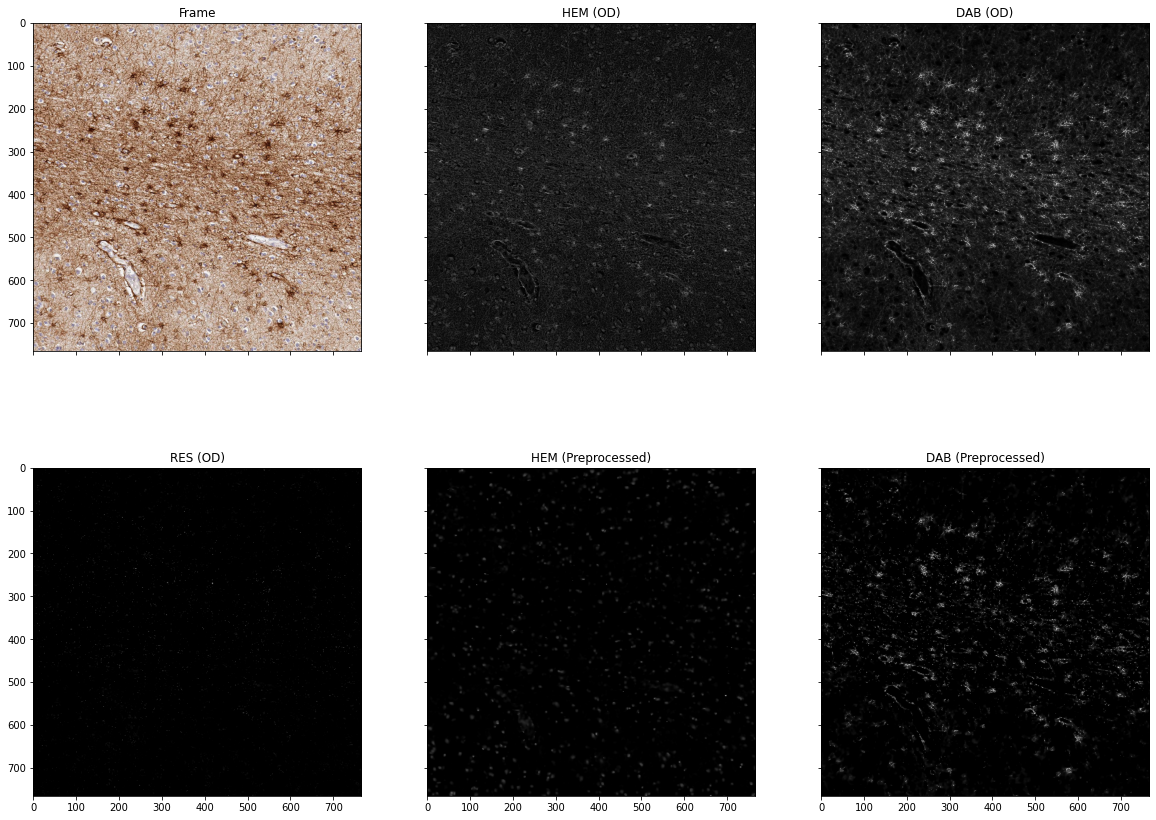

In [2]:
interactive_plots = False
if interactive_plots:
    %matplotlib qt
else:
    %matplotlib inline
    
# prepare the processor
kwargs = {
    'main_roi': main_roi,
    'sub_rois': sub_rois,
    'exclusion_rois': exclusion_rois,
}
processor = sana.process.HDABProcessor(
    logger, 
    frame, 
    apply_smoothing=True,      # performs an anisotropic diffusion filter on the DAB to smooth object interiors
    normalize_background=True, # flattens the DAB background
    **kwargs
)

## Part 2: Classify the DAB

Now that we have a grayscale DAB image, we will want to classify the pixels as positive or negative. This is done via a semi-automatically determined threshold and (optionally) a set of morphology filters

The threshold is selected using the triangular method. This method has a strictness parameter that can customize how the threshold is determined. The triangular method will then select a threshold for each ROI you provide based on the guidelines you've selected. In practice, this parameter should be set by evaluating the characteristics of the antibody you are analyzing. 

After, a set of morphology filters will be applied. These are useful for a variety of situations you may encounter any specific antibody. an Opening filter can delete small specs of DAB, while a Closing filter can fill holes in the DAB created by nuclei.


{'main_mask': <sana.image.Frame object at 0x110736c40>, 'sub_masks': [<sana.image.Frame object at 0x11077fe80>, <sana.image.Frame object at 0x1104828e0>], 'exclusion_mask': <sana.image.Frame object at 0x110736a00>, 'valid_mask': <sana.image.Frame object at 0x110736f70>, 'positive_dab': <sana.image.Frame object at 0x131817130>}


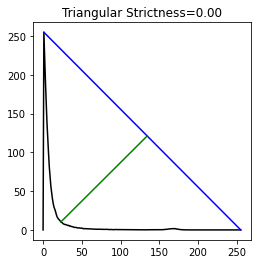

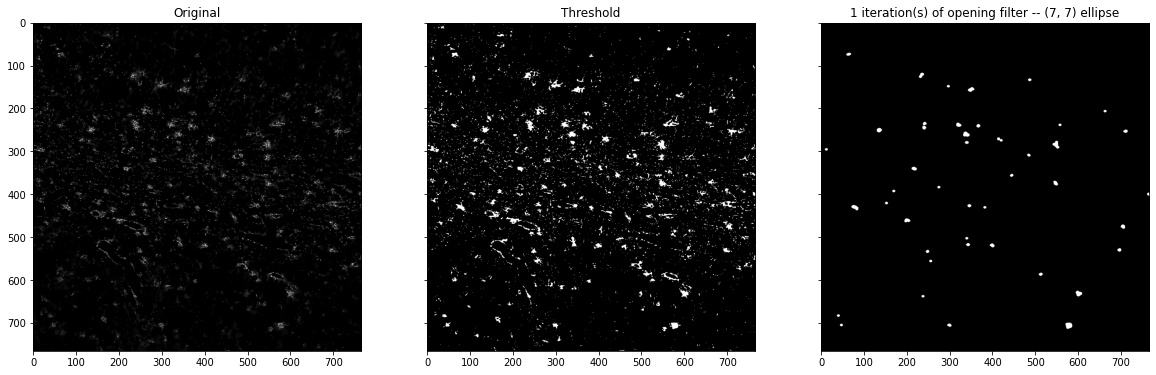

In [3]:
interactive_plots = False
if interactive_plots:
    %matplotlib qt
else:
    %matplotlib inline

morphology_filters = [
    # sana.filter.MorphologyFilter(filter_type='closing', kernel_type='ellipse', kernel_radius=2, n_iterations=1),
    sana.filter.MorphologyFilter(filter_type='opening', kernel_type='ellipse', kernel_radius=3, n_iterations=1),
]
results = processor.run(
    triangular_strictness=0.0, # range: (-1,1) from lenient to strict
    minimum_threshold=0, # failsafe in case you want to ensure that the threshold doesn't become too lenient in your sections
    od_threshold=None, # user defined pre-determined threshold in the optical density spectrum
    morphology_filters=morphology_filters, # further processes the thresholded DAB
)
print(results)